# Setting Up the Environment for Lakh Pianoroll Dataset

Follow these steps to set up the environment and prepare the dataset for use:

## 1. Create a Folder
Create a directory named `Lakh pianoroll dataset` to organize the dataset and associated files.

```bash
mkdir "Lakh pianoroll dataset"
cd "Lakh pianoroll dataset"
```
## 2. Download dataset
Download the following files from the official [Lakh Pianoroll Dataset website](https://hermandong.com/lakh-pianoroll-dataset/):

- `lpd_17_cleansed.tar.gz`
- `cleansed_ids.txt`

Save these files in the `Lakh pianoroll dataset` folder.

## 3. Extract the Dataset

Extract the contents of the `lpd_17_cleansed.tar.gz` file using the following command:

```bash
tar -xvzf lpd_17_cleansed.tar.gz
```

This will create a directory named lpd_17_cleansed in the Lakh pianoroll dataset folder.

## 4. Download and Extract Label Files

The label files to download from the Lakh Pianoroll Dataset website are:

- `id_lists_lastfm.tar.gz`
- `id_lists_amg.tar.gz`
- `id_lists_tagtraum.tar.gz`

### Steps to Download and Extract:
1. **Download the label files**:
   Download the following files from the [Lakh Pianoroll Dataset labels page](https://hermandong.com/lakh-pianoroll-dataset/labels):
   - `id_lists_lastfm.tar.gz`
   - `id_lists_amg.tar.gz`
   - `id_lists_tagtraum.tar.gz`

2. **Save them in the `Lakh pianoroll dataset` folder**:
   Place these `.tar.gz` files inside your `Lakh pianoroll dataset` directory.

3. **Create a `labels` folder**:
   ```bash
   mkdir labels
   ```
4. **Extract the labels into the `labels` folder:** Extract each `.tar.gz` file inside the `labels` folder:
```bash
tar -xvzf id_lists_lastfm.tar.gz -C labels/
tar -xvzf id_lists_amg.tar.gz -C labels/
tar -xvzf id_lists_tagtraum.tar.gz -C labels/
```


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install required packages

In [ ]:
!apt-get update -qq && apt-get install -qq fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!sudo apt-get install fluidsynth
!pip install torch-fidelity
!pip install pytorch-fid
!pip install pypianoroll
!pip install mir_eval
!pip install music21
!pip install triton

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 124565 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.3_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.3) ...
Setting up fluid-soundfont-gm (3.1-5.3) ...
update-alternatives: using /usr/share/sounds/sf2/FluidR3_GM.sf2 to provide /usr/share/sounds/sf2/default-GM.sf2 (default-GM.sf2) in auto mode
update-alternatives: using /usr/share/sounds/sf2/FluidR3_GM.sf2 to provide /usr/share/sounds/sf3/default-GM.sf3 (default-GM.sf3) in auto mode
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 55.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.6 MB/s eta 0:00:00
Reading package lists... Done
Building depende

In [ ]:
import matplotlib
print(matplotlib.__version__)

3.10.0


In [ ]:
!pip install matplotlib==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mir_eval
import mir_eval.display
import IPython.display
import os
import sys
import json
import time
import torch
import random
import tables
import librosa
import pathlib
import pretty_midi
import pypianoroll
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader, TensorDataset, Dataset
from IPython.display import HTML, display
from pytorch_fid import fid_score
from datetime import datetime
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from google.colab import drive
import re

## Change to the project directory

In [ ]:
cd "/content/drive/Shareddrives/Projects/PianorollGPT"

/content/drive/Shareddrives/Projects/PianorollGPT


## Generate dataset with tokens for each genre and each label.

In [ ]:
from utils import create_file_paths, get_random_song_ids, create_combined_pianorolls, generate_dataset

combined_pianorolls_path = 'pianorolls/'

file_paths = create_file_paths()

for file in file_paths[53 :]:
    if file.split('/')[-1].split('.')[0].startswith('masd'):
        continue
    label = file.split('/')[-2]
    genre = file.split('/')[-1].split('.')[0]
    print(f"{label} - {genre}")
    random_song_ids = get_random_song_ids([file], num_songs=2000)
    print(random_song_ids[:10])
    combined_pianorolls = create_combined_pianorolls(random_song_ids, f"{combined_pianorolls_path}/{label}_{genre}.pt")
    generate_dataset(combined_pianorolls, f"txtdatasets/dataset_{label}_{genre}.txt")


In [ ]:
import os

# Specify the directory containing the input files
input_directory = './txtdatasets'
output_directory = './txtdatasets_cleaned'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)
# Loop through all files in the input directory
for file_name in os.listdir(input_directory):
    input_file_path = os.path.join(input_directory, file_name)

    # Ensure we only process files, not directories
    if os.path.isfile(input_file_path):
        # Define the output file path
        output_file_path = os.path.join(output_directory, file_name)
        genre = ''.join(file_name.split('_')[-1].split(".")[0]).upper()

        # Open the input and output files
        with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
            for line in infile:
                # Clean the line by removing extra spaces
                # cleaned_line = ' '.join(line.strip().replace('<SOT>', f'<SOT> <{genre}>').replace('<beat>', f'<{genre}>').split())
                cleaned_line = ' '.join(line.strip().split())

                # Write the cleaned line to the output file
                outfile.write(cleaned_line + '\n')

print(f"Processing completed! Cleaned files are saved in '{output_directory}'.")

Processing completed! Cleaned files are saved in './txtdatasets_cleaned'.


In [ ]:
#Get information on number of songs in each genre and label
import os

# Specify the directory containing the input files
input_directory = './txtdatasets_cleaned'
genre_line_count = {}

# Loop through all files in the input directory
for file_name in os.listdir(input_directory):
    input_file_path = os.path.join(input_directory, file_name)

    # Ensure we only process files, not directories
    if os.path.isfile(input_file_path):
        # Define the output file path
        genre = ''.join(file_name.split('_')[-1].split(".")[0]).upper()
        line_count = 0
        # Open the input and output files
        with open(input_file_path, 'r') as infile:
            for line in infile:
                line_count += 1
        if genre in genre_line_count:
            genre_line_count[genre] += line_count
        else:
            genre_line_count[genre] = line_count


print(genre_line_count)

{'METAL': 697, 'RAP': 542, 'FOLK': 747, 'POP': 3086, 'JAZZ': 957, 'COUNTRY': 1871, 'BLUES': 661, 'REGGAE': 296, 'WORLD': 10, 'ROCK': 3668, 'NEW-AGE': 96, 'RNB': 661, 'LATIN': 430, 'ELECTRONIC': 1241, 'PUNK': 12, 'INTERNATIONAL': 206, 'VOCAL': 114, '60S': 1140, 'ACOUSTIC': 768, 'MELLOW': 1688, 'LOVED': 1024, 'PROGRESSIVE-ROCK': 0, 'CLASSIC-ROCK': 0, 'PSYCHEDELIC': 305, 'SOUNDTRACK': 1140, 'AMERICAN': 1814, '70S': 1579, 'ELECTRO': 488, 'HEARD-ON-PANDORA': 0, 'COVER': 730, 'LOVE': 2000, 'DOWNTEMPO': 316, 'AWESOME': 1733, 'GUITAR': 912, 'PARTY': 1836, 'LOUNGE': 411, 'FUNK': 742, 'RELAX': 792, 'SOUL': 1537, 'CATCHY': 1496, 'HIP-HOP': 477, '90S': 1984}


In [ ]:

import os
from collections import defaultdict

# Directory containing the text files
data_dir = "./txtdatasets_cleaned/"
# Dictionary to store genre groups
dataset_paths = []
# Extract genres from file names and group
for file_name in os.listdir(data_dir):
    if file_name.endswith(".txt"):
        # Extract genre token (e.g., "tagtraum_pop" from "dataset_tagtraum_pop.txt")
        genre = ''.join(file_name.split('_')[-1].split(".")[0]).upper()
        dataset_paths.append((genre, os.path.join(data_dir, file_name)))

In [ ]:
from utils import generate_dataset, max_tokens_in_line, average_tokens_per_line, view_dataset_sample

max_tokens_in_line('./txtdatasets_cleaned/dataset_tagtraum_id_list_Rock.txt')
average_tokens_per_line('./txtdatasets_cleaned/dataset_tagtraum_id_list_Rock.txt')
view_dataset_sample('./txtdatasets_cleaned/dataset_tagtraum_id_list_Rock.txt')

Maximum number of tokens in a single line: 49245
Line with maximum tokens: <SOT> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> <beat> D40 D50 <beat> <beat> <beat> <beat> D45 D47 <beat> <beat> <beat> <beat> D40 D50 <beat> <beat> D40 D50 <beat> <beat> D35 D42 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D35 D42 <beat> <beat> D40 D42 <beat> <beat> D42 <beat> <beat> D42 Per74 Per86 <beat> Per74 Per86 <beat> D35 D42 Per74 Per86 <beat> Per74 Per86 <beat> D35 D42 Per74 Per86 <beat> Per74 Per86 <beat> D42 Per74 Per86 <beat> Per74 Per86 <beat> D35 D42 Per74 Per86 <beat> Per74 Per86 <beat> D42 Per74 Per86 <beat> Per74 Per86 <beat> D40 D42 Per74 Per86 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D40 D42 <beat> <beat> D35 D42 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D35 D42 <beat> <beat> D40 D42 <beat> <beat> D42 <beat> <beat> D42 <beat> <beat> D35 D42 <beat> Per74 Per86 <beat> D35 D42 Per74 P

##Testing out dataloader

In [ ]:
from data_loader import PianoRollDataLoader
from tokenizer import PianoRollTokenizer
tokenizer = PianoRollTokenizer(dataset_paths=dataset_paths)
train_loader = PianoRollDataLoader(dataset_paths=dataset_paths, B=64, T=1024, device="cuda")
batch_x, batch_y = train_loader.next_batch()
print(batch_x[0])
print(batch_y[0])
# for i in range(len(train_loader.song_tokens[0])):
#     if '<PAD>' in tokenizer.decode(batch_y[0].tolist()):
#         print(tokenizer.decode(batch_x[0].tolist()))
#         break
#     else:
#         batch_x, batch_y = train_loader.next_batch()

/content/drive/Shareddrives/Projects/PianorollGPT/data_loader.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.song_tokens = torch.load("song_tokens2.pth")  # Load


tensor([32,  0, 41,  ...,  0, 46,  0])
tensor([   0,   41,    0,  ...,   46,    0, 1082])


In [ ]:
batch_x, batch_y = train_loader.next_batch()
print(batch_x[0])
print(batch_y[0])

tensor([ 11,  82,   0,  ..., 464,   0, 469])
tensor([ 82,   0, 437,  ...,   0, 469,   0])


In [ ]:
for i in range(len(train_loader.song_tokens[0])):
    if '<PAD>' in tokenizer.decode(batch_y[0].tolist()):
        print(batch_x[0][:10])
        print(batch_y[0][:10])
        print(tokenizer.decode(batch_x[0].tolist()))
        print(tokenizer.decode(batch_y[0].tolist()))
        break
    else:
        batch_x, batch_y = train_loader.next_batch()

tensor([  43,   93,    0,  471,    0,  483,    0, 1530,    0,  867])
tensor([  93,    0,  471,    0,  483,    0, 1530,    0,  867,    0])
<SOUNDTRACK> B41   E77   E89   R72   L65   <beat>   P53   P57   P60   B41   E77   E89   R72   L65   <beat>   D38   D39   D42   D54   D56   P53   P57   P60   G60   G64   G67   B41   E77   E89   R72   L64   L65   <beat>   P53   P57   P60   G60   G64   G67   B41   E77   E89   R72   L64   <beat>   P53   P57   P60   B41   E77   E89   R72   L60   L64   <beat>   D36   P53   P57   P60   B29   B41   E77   E89   R72   L60   <beat>   D36   D42   D56   P53   P57   P60   B29   B41   E77   E89   R72   L60   <beat>   P53   P57   P60   B41   E77   E89   R72   L60   <beat>   D36   P55   P59   P62   B41   E77   E89   R72   L60   <beat>   P55   P59   P62   B41   E77   E89   R72   L60   <beat>   D38   D42   D54   D56   P55   P59   P62   B41   B43   E77   E89   R72   L60   L62   <beat>   P55   P59   P62   B43   E77   E89   R72   L62   <beat>   D36   D46   P55   P59   P62

#Create a model instance

In [ ]:
from dataclasses import dataclass
from model import GPT
import math

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 2048
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768

total_batch_size = 65536
B = 32
T = 1024
assert total_batch_size % (B * T) == 0, "make sure the total batch size is divisible by B*T"
grad_accum_steps = total_batch_size // (B*T)

print(f"Total desired batch size {total_batch_size}")
print(f"=> Calculated gradient accumulation steps: {grad_accum_steps}")

using device: cuda
Total desired batch size 65536
=> Calculated gradient accumulation steps: 2


In [ ]:
from data_loader import PianoRollDataLoader

train_loader = PianoRollDataLoader(dataset_paths=dataset_paths, B=B, T=T, device=device)

/content/drive/Shareddrives/Projects/PianorollGPT/data_loader.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.song_tokens = torch.load("song_tokens2.pth")  # Load


In [ ]:

model = GPT(GPTConfig())
model.to(device)
model = torch.compile(model)
# Uncomment below line if we are resuming training
# model.load_state_dict(torch.load("./checkpoints_new/model_all_genre_checkpoint_step_13000.pth"))

max_lr = 3e-4
# max_lr = 5.6865e-05
# min_lr = max_lr * 0.1
min_lr = 5e-6
warmup_steps = 100
max_steps = 10000
def get_lr(it):
    if it < warmup_steps:
        return max_lr * (it+1)/warmup_steps
    if it >= max_steps:
        return min_lr

    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0<=decay_ratio<1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff*(max_lr - min_lr)
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
optimizer = model.configure_optimizer(weight_decay=0.1, learning_rate=3e-4, device=device)

<ipython-input-6-1d0505963500>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints_new/model_all_genre_checkpoint_step_13000.pth

Num of decayed parameter tensors: 50, with 87,293,952 parameters
Num of non-decayed parameter tensors: 98, with 121,344 parameters
Using fused AdamW: True


In [ ]:
import time
import torch
import matplotlib.pyplot as plt

# Variables to store loss for plotting
losses = []

# Training loop
for step in range(0, 50000):
    t0 = time.time()
    optimizer.zero_grad()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x = x.to(device)
        y = y.to(device)
        logits, loss = model(x, y)
        del x, y
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize()
    t1 = time.time()
    dt = (t1 - t0) * 1000
    tokens_per_sec = (train_loader.B * train_loader.T * grad_accum_steps) / (t1 - t0)

    # Store the accumulated loss for plotting
    losses.append(loss_accum.item())

    print(f"Step {step:4d} | loss: {loss_accum.item():.6f} | lr: {lr:.4e} | norm: {norm:.4f} | dt: {dt:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

    # Save model checkpoint every 5000 steps
    if (step + 1) % 500 == 0:
        checkpoint_filename = f"model_all_genre_checkpoint_step_{step + 1}.pth"
        checkpoint_filepath = os.path.join("./checkpoints_new", checkpoint_filename)
        torch.save(model.state_dict(), checkpoint_filepath)
        print(f"Checkpoint saved at step {step + 1}: {checkpoint_filename}")

# Save final model
torch.save(model.state_dict(), "model_state_dict.pth")
print("Final model saved.")

Step 14500 | loss: 0.783457 | lr: 5.0000e-06 | norm: 0.9330 | dt: 4692.28ms | tok/sec: 13966.78
Step 14501 | loss: 0.667058 | lr: 5.0000e-06 | norm: 0.6833 | dt: 4784.76ms | tok/sec: 13696.81
Step 14502 | loss: 1.086874 | lr: 5.0000e-06 | norm: 2.3822 | dt: 4856.02ms | tok/sec: 13495.84
Step 14503 | loss: 1.238657 | lr: 5.0000e-06 | norm: 0.9771 | dt: 4873.60ms | tok/sec: 13447.15
Step 14504 | loss: 0.879379 | lr: 5.0000e-06 | norm: 1.2658 | dt: 4892.87ms | tok/sec: 13394.18
Step 14505 | loss: 1.039340 | lr: 5.0000e-06 | norm: 1.1109 | dt: 4932.76ms | tok/sec: 13285.86
Step 14506 | loss: 0.974571 | lr: 5.0000e-06 | norm: 0.8043 | dt: 4924.42ms | tok/sec: 13308.36
Step 14507 | loss: 0.946032 | lr: 5.0000e-06 | norm: 0.8775 | dt: 4876.59ms | tok/sec: 13438.90
Step 14508 | loss: 0.987146 | lr: 5.0000e-06 | norm: 0.8557 | dt: 4834.55ms | tok/sec: 13555.75
Step 14509 | loss: 0.651513 | lr: 5.0000e-06 | norm: 0.6179 | dt: 4808.29ms | tok/sec: 13629.80
Step 14510 | loss: 0.851230 | lr: 5.0000

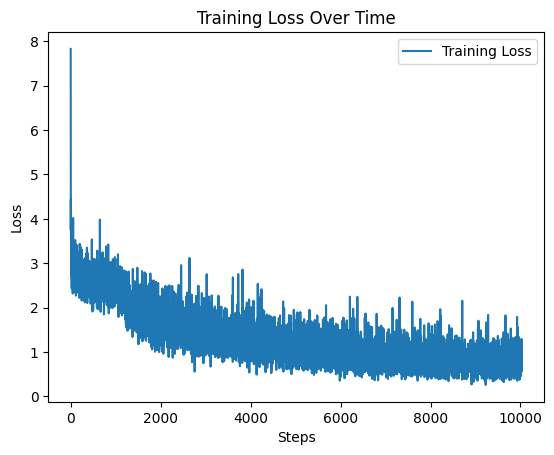

In [ ]:
# Plot the loss over time
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

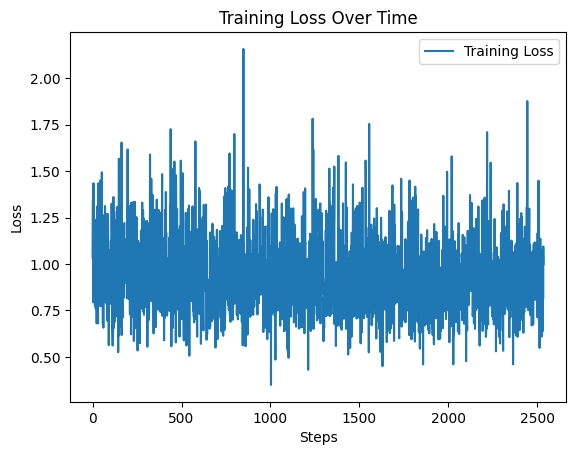

In [ ]:
# Plot the loss over time
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [ ]:
#Use this to load the model
model = GPT(GPTConfig())
model.to(device)
model = torch.compile(model)

model.load_state_dict(torch.load("./checkpoints_new/model_all_genre_checkpoint_step_15500.pth"))
model.eval()

<ipython-input-5-6a3a12d3d1af>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints_new/model_all_genre_checkpoint_step_15500.pth

OptimizedModule(
  (_orig_mod): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(2048, 768)
      (wpe): Embedding(1024, 768)
      (h): ModuleList(
        (0-11): 12 x Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=768, out_features=2304, bias=True)
            (c_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='tanh')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=2048, bias=False)
  )
)

#Generate songs

In [ ]:
from tokenizer import PianoRollTokenizer
# Create the tokenizer
tokenizer = PianoRollTokenizer(dataset_paths=dataset_paths)

In [ ]:
from utils import detokenize_sequence
def generate_music(genre, idx=None):
    generated_output = model.generate(None, tokenizer, max_new_tokens=8192, genre_token=genre, temperature=0.9, top_k=25)
    predicted_tokens = tokenizer.decode(generated_output[0].tolist())
    predicted_tokens = predicted_tokens.replace('<SOT>', '').replace('<PAD>', '').replace('<EOT>', '').replace(genre, '').strip()
    predicted_tokens=predicted_tokens.split("<beat>")
    num_time_steps = len(predicted_tokens)
    predicted_tensor = detokenize_sequence(predicted_tokens, num_time_steps)
    return predicted_tensor

In [ ]:
predicted_tensor = generate_music("<COVER>")

Streaming output truncated to the last 5000 lines.
 
D42
 
D69
 
P38
 
P43
 
P57
 
P62
 
P65
 
G50
 
G53
 
G57
 
G60
 
G62
 
G64
 
B38
 
E50
 
E50
 
E53
 
E57
 
E62
 
<beat>
 
D42
 
D54
 
P38
 
P43
 
P57
 
P60
 
P62
 
P64
 
P67
 
G52
 
G57
 
G62
 
B38
 
E50
 
E53
 
E57
 
E62
 
<beat>
 
D35
 
D42
 
D54
 
D54
 
P38
 
P43
 
P57
 
P60
 
P69
 
G50
 
G52
 
G57
 
G60
 
G62
 
G65
 
B38
 
E50
 
E53
 
E57
 
E62
 
<beat>
 
D39
 
D44
 
D54
 
D69
 
P42
 
P43
 
P57
 
P60
 
P62
 
P69
 
G50
 
G53
 
G57
 
G62
 
G65
 
B38
 
E50
 
E53
 
E57
 
<beat>
 
D40
 
D42
 
D69
 
P43
 
P57
 
P60
 
P62
 
P67
 
G50
 
G53
 
G57
 
G62
 
G65
 
B38
 
E50
 
E53
 
E57
 
E62
 
<beat>
 
P38
 
P57
 
P62
 
P67
 
P69
 
G53
 
G57
 
G62
 
B38
 
E50
 
E53
 
E57
 
E62
 
<beat>
 
D42
 
D69
 
P38
 
P57
 
P60
 
P62
 
P69
 
G50
 
G53
 
G57
 
G62
 
G65
 
B38
 
E50
 
E53
 
E57
 
E62
 
<beat>
 
D42
 
D69
 
P38
 
P57
 
P60
 
P62
 
P69
 
G50
 
G53
 
G57
 
G62
 
G65
 
B38
 
E50
 
E53
 
E57
 
E62
 
<beat>
 
D42
 
D54
 
D70
 
P43
 
P57
 
P62
 

In [ ]:
a = predicted_tensor.contiguous()
a = a.view(1, -1, 128).squeeze(0).detach().cpu().numpy()

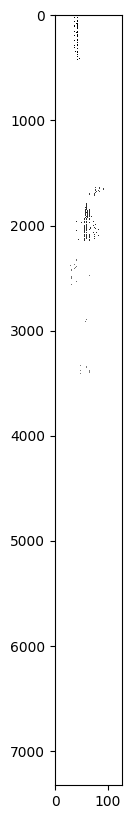

In [ ]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.imshow(a, cmap = 'gray_r', interpolation = 'nearest')
ax.set_aspect(0.2)
plt.show()

In [ ]:
# Convert predictions into the multitrack pianoroll for the first song
pianoroll_numpy = predicted_tensor.detach().cpu().numpy()

# Define the program numbers for the tracks
programs = {
 'Drums': 0,
 'Piano': 0,
 'Chromatic Percussion': 8,
 'Organ': 16,
 'Guitar': 24,
 'Bass': 32,
 'Strings': 40,
 'Ensemble': 48,
 'Brass': 56,
 'Reed': 64,
 'Pipe': 72,
 'Synth Lead': 80,
 'Synth Pad': 88,
 'Synth Effects': 96,
 'Ethnic': 104,
 'Percussive': 112,
 'Sound Effects': 120
}

# Define the track names in the same order as they were stacked
track_names = [
    'Drums', 'Piano', 'Chromatic Percussion', 'Organ', 'Guitar',
    'Bass',
    'Strings', 'Ensemble', 'Brass', 'Reed', 'Pipe', 'Synth Lead', 'Synth Pad',
    'Synth Effects', 'Ethnic', 'Percussive', 'Sound Effects'
]

# Create the tracks
tracks = []
for i, track_name in enumerate(track_names):
    is_drum = track_name == 'Drums'
    track = pypianoroll.StandardTrack(
        name=track_name,
        program=programs[track_name],
        is_drum=is_drum,
        pianoroll=pianoroll_numpy[i]
    )
    tracks.append(track)

# Create the multitrack object
predicted_multitrack = pypianoroll.Multitrack(name='Original', resolution=4, tracks=tracks)

In [ ]:
predicted_pm = pypianoroll.to_pretty_midi(predicted_multitrack)
predicted_midi_audio = predicted_pm.fluidsynth()
IPython.display.Audio(predicted_midi_audio, rate=44100)

In [ ]:
pypianoroll.write('finalsongs/COVER.mid', predicted_multitrack)